In [1]:
from ModelTransfuser.ModelTransfuser import *
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch

from scipy.stats import norm

import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/ModelTransfuser/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

# --- add noise ---
pc_ab = 5 # percentage error in abundance

train_y_err = torch.ones_like(train_y)*float(pc_ab)/100.
train_y = norm.rvs(loc=train_y,scale=train_y_err)
train_y = torch.tensor(train_y).float()

val_y_err = torch.ones_like(val_y)*float(pc_ab)/100.
val_y = norm.rvs(loc=val_y,scale=val_y_err)
val_y = torch.tensor(val_y).float()

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define ModelTransfuser

In [4]:
# Define the ModelTransfuser

# Time steps for the diffusion process
T = 20
t = torch.linspace(0, 1, T)

model = ModelTransfuser(T, train_data.shape)

model = model.load('ModelTransfuser/models/ModelTransfuser_e100_s101_lr_10000data.pickle')

In [5]:
#with open('ModelTransfuser/models/ModelTransfuser_test.pickle', 'rb') as f:
#    model = pickle.load(f)

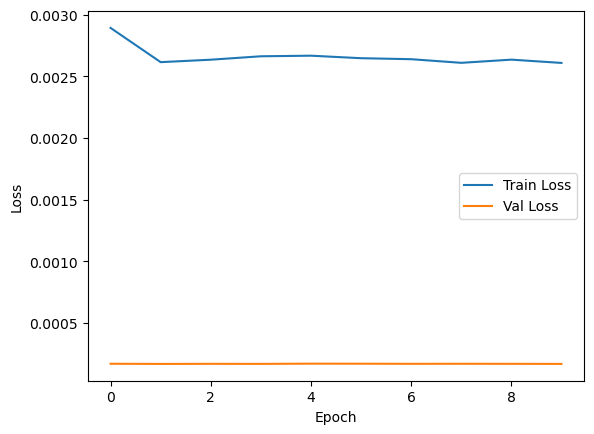

In [6]:
epoch = np.arange(0, len(model.train_loss))

plt.plot(epoch, np.array(model.train_loss)/10000, label='Train Loss')
plt.plot(epoch, np.array(model.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
#model.set_normalization(train_data)
#model.train(train_data[:1000], val_data=val_data, epochs=10, device="cuda:1")

## Data Generation

In [8]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]

In [9]:
mask = torch.zeros_like(val_data[0])
mask[6:] = 1

In [10]:
#sample_data_t1 = torch.randn(val_data.shape)*(1-mask)+(mask*val_data)

In [11]:
data = val_data[:1000, mask.type(torch.bool)]

In [10]:
p3=model.sample(data, condition_mask=mask, device="cuda:1").to("cpu")

100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


In [53]:
#p = model.sample(val_data[:1000], condition_mask=mask.repeat(1000,1), device="cuda:1").to("cpu")

In [11]:
torch.mean(100*torch.abs((val_data[:1000]-p3.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([100.0309, 100.1120, 136.3855,  99.7590,  99.8293,  99.9716])

In [54]:
torch.mean(100*torch.abs((val_data[:1000]-p3.mean(axis=1))/val_data[:1000]), axis=0)[:6]

tensor([ 10.6909,   8.2379, 352.6056,  15.2206,  17.7711,  81.9690])

In [15]:
p=model.sample(data[1], condition_mask=mask, device="cuda:1").to("cpu")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [16:05<?, ?it/s]


KeyboardInterrupt: 

In [13]:
val_data[1,:5]

tensor([-2.0697, -2.7872, -0.3723,  0.4962,  0.4666])

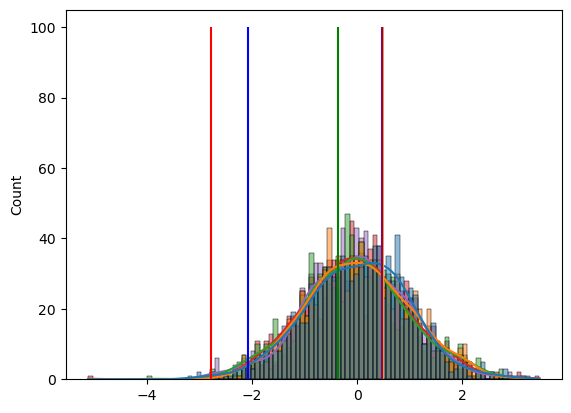

In [14]:
sns.histplot(p[0,:,:5], bins=100, kde=True,color=['blue','red','green','orange','purple'], legend=False)
plt.vlines(val_data[1,:5], 0, 100, color=['blue','red','green','orange','purple'])
#plt.vlines(val_data[1,0], 0, 10, color='red')
plt.show()

In [ ]:
p2 = model.sample(val_data[:1000], condition_mask=(-1)*(mask.repeat(1000,1)-1), device="cuda:1").to("cpu")

In [ ]:
torch.mean(100*torch.abs((val_data[:1000]-p2.mean(axis=1))/val_data[:1000]), axis=0)[6:]

In [ ]:
#sns.histplot(p2[1,:,6:], bins=1000, kde=True )
sns.kdeplot(p2[1,:,6:], bw_adjust=0.1)
plt.show()

In [13]:
#scaling_factor = -0.5*model.sigma**(2*t)*(1/T)
denoising_data = model.x_t.detach().numpy()
#denoising_data = denoising_data * (model.std.detach().numpy() + 1e-6) + model.mean.detach().numpy()
score_t = model.score_t.detach().numpy()
dx = model.dx_t.detach().numpy()
t = model.t.detach().numpy()

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 500  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,2)
    plt.ylim(-5,2)
    plt.xlabel(r'$\alpha_{IMF}$')
    plt.ylabel(r'$\log_{10}N$')
    plt.title(f'Denoising Timestep: {i}')
    
    sns.set_style("white")
    sns.kdeplot(x=denoising_data[0,i,:,0], y=denoising_data[0,i,:,1], cmap='Blues', fill=True, levels=100, bw_adjust=0.6)
    plt.tight_layout()

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=20) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                bitrate=-1)
ani2.save('plots/test_new.gif', writer=writer)

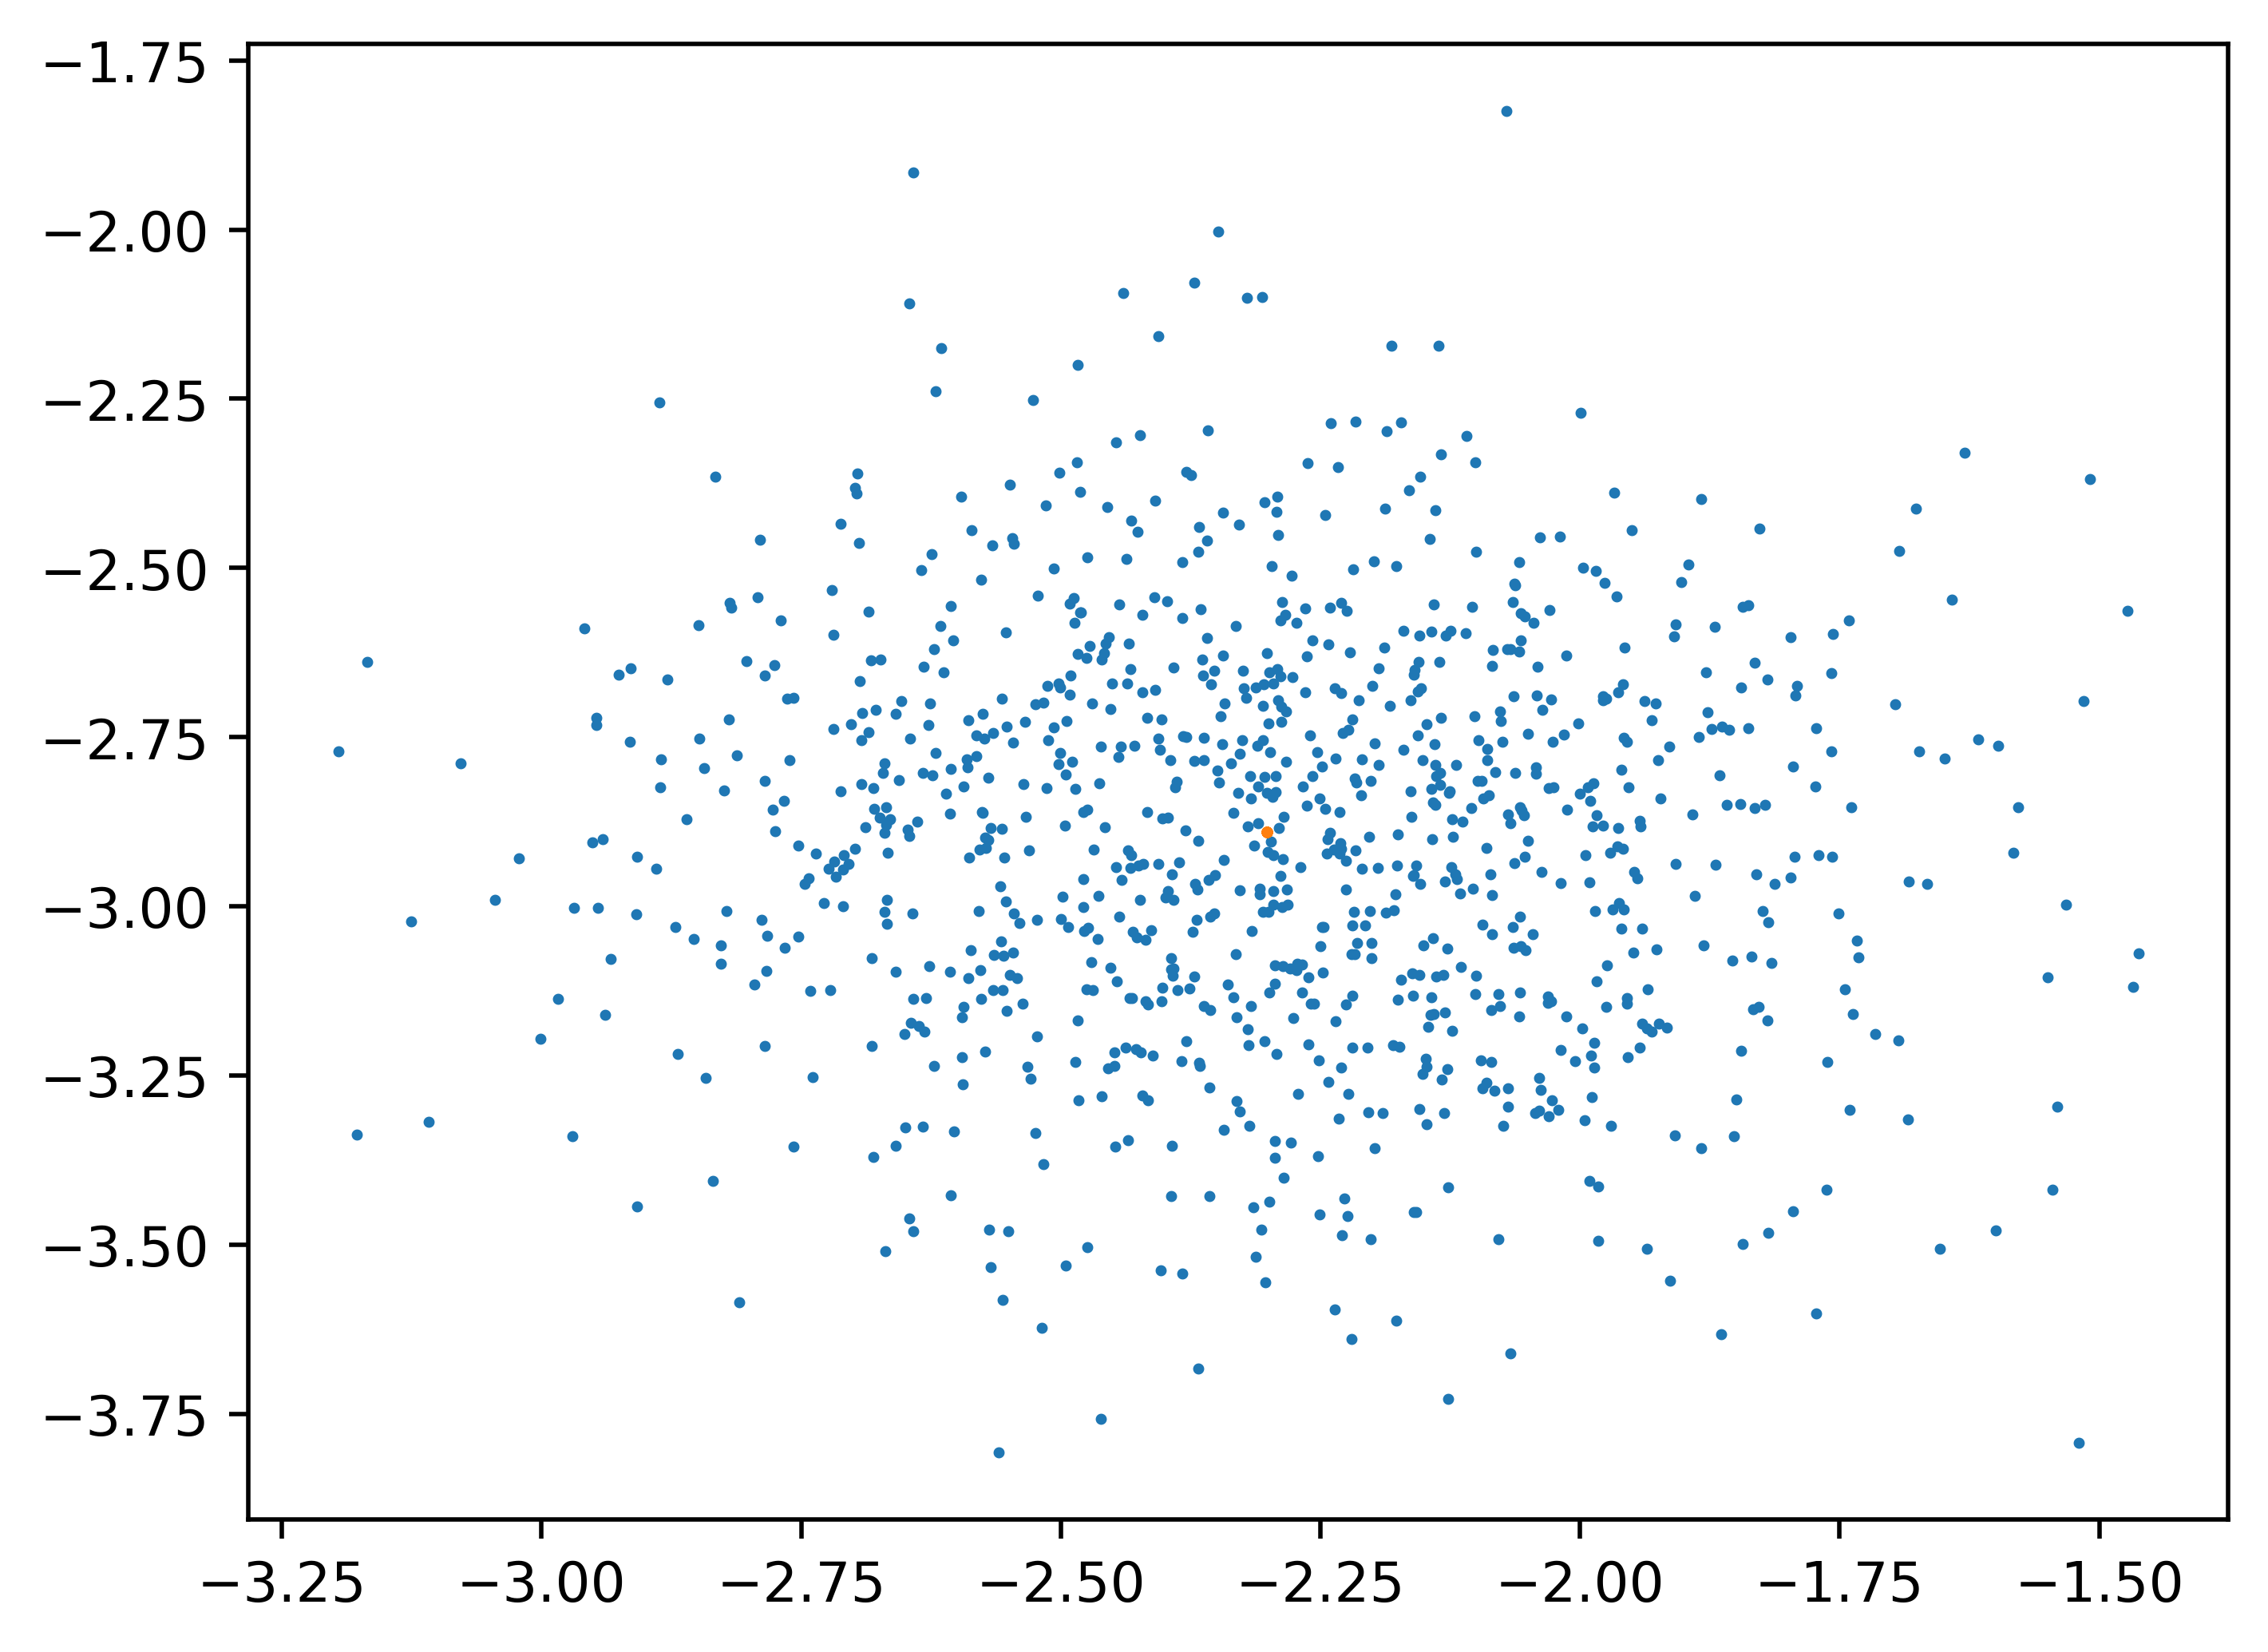

In [41]:
plt.scatter(denoising_data[0,0,:,0], denoising_data[0,0,:,1], s=1)
plt.scatter(denoising_data[0,-1,:,0], denoising_data[0,-1,:,1], s=1)
plt.show()

In [33]:
denoising_data[0,:,0,:] * (model.std.detach().numpy() + 1e-6) + model.mean.detach().numpy()

array([[-2.0978179e+00, -2.5413437e+00, -1.8547341e-01,  5.4281795e-01,
         4.6631348e-01,  6.9432120e+00, -1.3468194e-01, -2.5653130e-01,
         1.7707948e-01, -2.4739265e-02, -6.2261000e-03,  2.1408984e-01,
         6.2758088e-02,  6.1980158e-02],
       [-2.0978181e+00, -2.5413454e+00, -1.8547365e-01,  5.4281837e-01,
         4.6631324e-01,  6.9431963e+00, -1.3468194e-01, -2.5653130e-01,
         1.7707948e-01, -2.4739265e-02, -6.2261000e-03,  2.1408984e-01,
         6.2758088e-02,  6.1980158e-02],
       [-2.0978181e+00, -2.5413468e+00, -1.8547499e-01,  5.4281938e-01,
         4.6631283e-01,  6.9431767e+00, -1.3468194e-01, -2.5653130e-01,
         1.7707948e-01, -2.4739265e-02, -6.2261000e-03,  2.1408984e-01,
         6.2758088e-02,  6.1980158e-02],
       [-2.0978148e+00, -2.5413480e+00, -1.8547514e-01,  5.4281902e-01,
         4.6631259e-01,  6.9431953e+00, -1.3468194e-01, -2.5653130e-01,
         1.7707948e-01, -2.4739265e-02, -6.2261000e-03,  2.1408984e-01,
         6.27

In [34]:
p3[0,0,0]

tensor(-2.0978)